# Enhancing Satellite Image Classification with Data Augmentation Techniques to Address Class Imbalance
## With balanced data 
### Improting libraries

The basic setup of the model(before grid searching) is taken from 
https://www.kaggle.com/code/dsrhul/agricultural-drought-prediction

In [1]:
#import the necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.io import imshow

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Reading Data

**Dataset:** [DeepSat-Sat4](https://www.kaggle.com/crawford/deepsat-sat4)

The input data is encoded in CSV files. Specifically, the `X_test_sat4.csv` file contains flattened images that were originally \(28 \times 28\) pixels with 4 channels. These images, taken from space, have the first three channels representing the standard red, green, and blue bands, while the fourth channel represents a near-infrared band.

We will use the smaller test set (`X_test_sat4.csv`) for this example, as the training set is too large. After extracting the data from the CSV files, we will reshape it into the original $28 \times 28 \times 4$ images.

Additionally, we will load the labels from the second file, which indicate the class of each image. The possible classes are:
1. Barren land
2. Trees
3. Grassland
4. Other

Each label is a one-hot encoded vector such as \([1, 0, 0, 0]\), where a \(1\) in a specific position indicates the class of the image. For example:
- \([1, 0, 0, 0]\) indicates barren land.
- \([0, 1, 0, 0]\) indicates trees.
- \([0, 0, 1, 0]\) indicates grassland.
- \([0, 0, 0, 1]\) indicates other.

Let's start by loading and reshaping the data.

In [3]:
#Reading dataset
X = pd.read_csv("../input/deepsat-sat4/X_test_sat4.csv") #values are in DataFrame format
Y = pd.read_csv("../input/deepsat-sat4/y_test_sat4.csv") #values are in DataFrame format
X = np.array(X) # converting Dataframe to numpy array
Y = np.array(Y) # converting Dataframe to numpy array

In [4]:
#Shape of data used
print("Train data shape: ",X.shape)

Train data shape:  (99999, 3136)


### Preprocessing
The data is reshaped, standarlize. The training data is balanced.  

In [5]:
#reshaping (99999, 3136) to (99999, 28, 28, 4)
X = X.reshape([99999,28,28,4]).astype(float)
print("Reshaped data format: ",X.shape)

Reshaped data format:  (99999, 28, 28, 4)


In [6]:
# Standardization
X = X / 255.0

# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
y_test.shape

(20000, 4)

In [7]:
import random

# Set a seed
random.seed(4643)  


def balance_classes(X_train, y_train, min_count=10000):
    # Determine unique classes and their counts
    unique_classes, class_counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
    
    X_balanced = []
    y_balanced = []
    
    # Iterate over each class
    for cls in unique_classes:
        class_indices = np.where(np.argmax(y_train, axis=1) == cls)[0]
        np.random.shuffle(class_indices)
        selected_indices = class_indices[:min_count]  # Select indices to balance the class
        X_balanced.append(X_train[selected_indices])
        y_balanced.append(y_train[selected_indices])
    
    # Concatenate balanced data arrays
    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)
    
    return X_balanced, y_balanced

X_train, y_train = balance_classes(X_train, y_train)

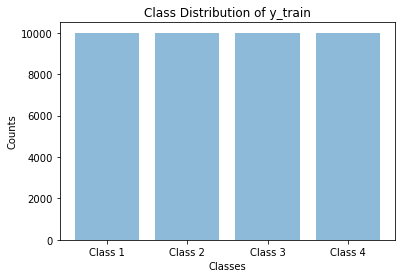

In [8]:
# Calculate class distribution
class_counts = np.sum(y_train, axis=0)

# Plotting
fig, ax = plt.subplots()
ax.bar(np.arange(len(class_counts)), class_counts, align='center', alpha=0.5)
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution of y_train')
ax.set_xticks(np.arange(len(class_counts)))
ax.set_xticklabels(['Class {}'.format(i+1) for i in range(len(class_counts))])
plt.show()

### Creating model and train it, then predict


In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU

# Define the number of classes
num_classes = 4

# Initialize the model
model = Sequential()

# Add layers sequentially
model.add(Conv2D(128, kernel_size=(3, 3), activation='linear', input_shape=(28, 28, 4), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))

# Output layer: Dense layer with num_classes and softmax activation
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 128)       4736      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [20]:
import time
random.seed(4543)
# Start time
start_time = time.time()
#fitting the data into the model
model.fit(X_train,y_train,batch_size=64, epochs=10, verbose=1, validation_split=0.20)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 105s 3ms/step - loss: 0.3172 - accuracy: 0.8773 - val_loss: 0.6463 - val_accuracy: 0.7444
Epoch 2/10
32000/32000 [==============================] - 92s 3ms/step - loss: 0.1554 - accuracy: 0.9426 - val_loss: 1.1788 - val_accuracy: 0.6093
Epoch 3/10
32000/32000 [==============================] - 93s 3ms/step - loss: 0.1220 - accuracy: 0.9572 - val_loss: 0.0659 - val_accuracy: 0.9754
Epoch 4/10
32000/32000 [==============================] - 93s 3ms/step - loss: 0.1016 - accuracy: 0.9641 - val_loss: 0.2703 - val_accuracy: 0.9015
Epoch 5/10
32000/32000 [==============================] - 93s 3ms/step - loss: 0.0975 - accuracy: 0.9655 - val_loss: 0.3216 - val_accuracy: 0.8954
Epoch 6/10
32000/32000 [==============================] - 93s 3ms/step - loss: 0.0902 - accuracy: 0.9678 - val_loss: 0.7882 - val_accuracy: 0.8871
Epoch 7/10
32000/32000 [==============================] - 92s 3ms/st

In [23]:
# Predicting model performance
preds = model.predict(X_test, verbose=1)

# Convert predictions to class labels (if necessary)
preds_labels = np.argmax(preds, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Model performance evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, preds_labels)
print("Accuracy score: ", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, preds_labels)
print("Confusion matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test_labels, preds_labels)
print("Classification report:")
print(class_report)

# Calculate categorical cross-entropy (log loss)
cat_crossentropy = log_loss(y_test, preds)
print("Categorical Cross-Entropy: ", cat_crossentropy)

20000/20000 [==============================] - 15s 775us/step
Accuracy score:  0.94995
Confusion matrix:
[[4948    9  226    8]
 [   0 4026    7    0]
 [  23   57 3561    0]
 [ 328  273   70 6464]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5191
           1       0.92      1.00      0.96      4033
           2       0.92      0.98      0.95      3641
           3       1.00      0.91      0.95      7135

    accuracy                           0.95     20000
   macro avg       0.94      0.96      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Categorical Cross-Entropy:  0.2362926986069173


### To further improve the model we grid searched over a set of hyper parameters.

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.metrics import make_scorer
import keras.backend as K
import tensorflow as tf

random.seed(4643)
# Define the scoring metric
from sklearn.metrics import accuracy_score


def create_model(filters=32, kernel_size=(3, 3), pool_size=(2, 2), dropout=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='linear', input_shape=(28, 28, 4), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='linear', padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, padding='same'))

    model.add(Flatten())
    model.add(Dense(filters, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(dropout))

    model.add(Dense(4, activation='softmax'))  # num_classes = 4 already defined

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [(2, 2), (3, 3)],
    'pool_size': [(2, 2)],
    'dropout': [0],
    'optimizer': ['adam']
}

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=1, validation_split=0.20)

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_log_loss", cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)


print("Best score: {:.4f}".format(grid_result.best_score_))
print("Best parameters:", grid_result.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 77.0min finished


Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 24s 765us/step - loss: 0.3424 - accuracy: 0.8659 - val_loss: 0.8794 - val_accuracy: 0.5558
Epoch 2/10
32000/32000 [==============================] - 21s 654us/step - loss: 0.1921 - accuracy: 0.9301 - val_loss: 0.3081 - val_accuracy: 0.9060
Epoch 3/10
32000/32000 [==============================] - 20s 628us/step - loss: 0.1474 - accuracy: 0.9484 - val_loss: 0.3462 - val_accuracy: 0.8904
Epoch 4/10
32000/32000 [==============================] - 20s 630us/step - loss: 0.1286 - accuracy: 0.9545 - val_loss: 0.2568 - val_accuracy: 0.9160
Epoch 5/10
32000/32000 [==============================] - 20s 630us/step - loss: 0.1090 - accuracy: 0.9616 - val_loss: 0.1966 - val_accuracy: 0.9413
Epoch 6/10
32000/32000 [==============================] - 20s 614us/step - loss: 0.1008 - accuracy: 0.9646 - val_loss: 0.0809 - val_accuracy: 0.9736
Epoch 7/10
32000/32000 [==============================] -

In [18]:
# Save the cv model
import pickle

# Serialize the grid_result object
with open('/kaggle/working/grid_result.pkl', 'wb') as file:
    pickle.dump(grid_result, file)

In [24]:
# Recreate a model with the optimal parameters.  than train and evaluate the performance
model_opt = create_model(dropout = 0, filters = 32, kernel_size = (3, 3), optimizer = 'adam', pool_size = (2,2))
model_opt.fit(X_train,y_train,batch_size=64, epochs=10, verbose=1, validation_split=0.20)



# Predicting model performance
preds = model_opt.predict(X_test, verbose=1)

# Convert predictions to class labels (if necessary)
preds_labels = np.argmax(preds, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Model performance evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, preds_labels)
print("Accuracy score: ", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, preds_labels)
print("Confusion matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test_labels, preds_labels)
print("Classification report:")
print(class_report)

# Calculate categorical cross-entropy (log loss)
cat_crossentropy = log_loss(y_test, preds)
print("Categorical Cross-Entropy: ", cat_crossentropy)


Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 18s 557us/step - loss: 0.3638 - accuracy: 0.8572 - val_loss: 1.0499 - val_accuracy: 0.5742
Epoch 2/10
32000/32000 [==============================] - 18s 558us/step - loss: 0.2116 - accuracy: 0.9212 - val_loss: 0.5293 - val_accuracy: 0.8091
Epoch 3/10
32000/32000 [==============================] - 18s 548us/step - loss: 0.1762 - accuracy: 0.9363 - val_loss: 0.2566 - val_accuracy: 0.9255
Epoch 4/10
32000/32000 [==============================] - 18s 558us/step - loss: 0.1400 - accuracy: 0.9515 - val_loss: 0.4131 - val_accuracy: 0.8755
Epoch 5/10
32000/32000 [==============================] - 17s 538us/step - loss: 0.1287 - accuracy: 0.9544 - val_loss: 0.2488 - val_accuracy: 0.9210
Epoch 6/10
32000/32000 [==============================] - 18s 551us/step - loss: 0.1064 - accuracy: 0.9639 - val_loss: 0.4137 - val_accuracy: 0.8660
Epoch 7/10
32000/32000 [==============================] -

### Now start our downsampling-upsampling analysis
First define a function to down sample a certain class to a certain percentage in the dataset.

In [32]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

def undersample_classes(class_label, y_train, X_train, target_percentage=0.1):
    """
    Undersample the specified class label until it represents a specified percentage of the dataset.
    
    Parameters:
    - class_label: int, the class label (0 to 3) to undersample.
    - y_train: numpy array, shape (n_samples, 4), containing one-hot encoded class labels.
    - X_train: numpy array, shape (n_samples, 28, 28, 4), containing training image data.
    - target_percentage: float, target percentage of the total dataset that the class should represent (default: 0.1).
    
    Returns:
    - y_train_undersampled: numpy array, undersampled y_train.
    - X_train_undersampled: numpy array, undersampled X_train.
    """
    # Validate inputs
    if class_label < 0 or class_label > 3:
        raise ValueError("class_label must be an integer between 0 and 3.")
    if not (0.0 <= target_percentage <= 100.0):
        raise ValueError("target_percentage must be between 0.0 and 100.0.")
    
    # Count occurrences of class_label
    class_indices = np.where(y_train[:, class_label] == 1)[0]
    num_class_samples = len(class_indices)
    
    # Calculate current percentage of the dataset
    current_percentage = (num_class_samples / len(y_train)) * 100.0
    
    # Calculate target number of samples for the class
    target_num_samples = int((target_percentage / 100.0) * len(y_train))
    
    # If current percentage is already less than or equal to target_percentage, return original data
    if current_percentage <= target_percentage:
        print(f"Class {class_label} already represents {current_percentage:.2f}% of the dataset. No undersampling needed.")
        return y_train, X_train
    
    # Calculate number of samples to drop
    num_samples_to_drop = num_class_samples - target_num_samples
    
    # Randomly select samples to drop
    samples_to_drop = np.random.choice(class_indices, size=num_samples_to_drop, replace=False)
    
    # Create masks to filter out dropped samples
    keep_mask = np.ones(len(y_train), dtype=bool)
    keep_mask[samples_to_drop] = False
    
    # Undersampled data
    y_train_undersampled = y_train[keep_mask]
    X_train_undersampled = X_train[keep_mask]
    
    print(f"Undersampled class {class_label} to achieve {target_percentage:.2f}% representation.")
    return y_train_undersampled, X_train_undersampled



In [40]:
# Define a funciton to train and report an undersampled dataset with optimal model
def train_undersampled_models(class_label, y_train, X_train, target_percentage=0.1):    
    y_train_undersampled, X_train_undersampled = undersample_classes(class_label, y_train, X_train, target_percentage)

    # Verify the class distribution after undersampling
    print(f"Class distribution after undersampling: {Counter(np.argmax(y_train_undersampled, axis=1))}")
    #fitting the data into the model
    random.seed(4643)
    model_opt.fit( X_train_undersampled,y_train_undersampled,batch_size=64, epochs=10, verbose=0, validation_split=0.20)
    # Predicting model performance
    preds = model_opt.predict(X_test, verbose=0)

    # Convert predictions to class labels (if necessary)
    preds_labels = np.argmax(preds, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Model performance evaluation
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, preds_labels)
    print("Accuracy score: ", accuracy)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, preds_labels)
    print("Confusion matrix:")
    print(conf_matrix)

    # Print classification report
    class_report = classification_report(y_test_labels, preds_labels)
    print("Classification report:")
    print(class_report)

    # Calculate categorical cross-entropy (log loss)
    cat_crossentropy = log_loss(y_test, preds)
    print("Categorical Cross-Entropy: ", cat_crossentropy)


In [41]:
train_undersampled_models(0, y_train, X_train, 0.1)

Undersampled class 0 to achieve 0.10% representation.
Class distribution after undersampling: Counter({1: 10000, 2: 10000, 3: 10000, 0: 40})
Accuracy score:  0.93105
Confusion matrix:
[[3925    2  617  647]
 [   0 4025    5    3]
 [   2   42 3579   18]
 [   2   32    9 7092]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      5191
           1       0.98      1.00      0.99      4033
           2       0.85      0.98      0.91      3641
           3       0.91      0.99      0.95      7135

    accuracy                           0.93     20000
   macro avg       0.94      0.93      0.93     20000
weighted avg       0.94      0.93      0.93     20000

Categorical Cross-Entropy:  0.279079302898729


### Now start to use techniques to solve class imbalance by upsampling
First we will treat the data as purely as numerical values and use random sampling and smote to upsample the imbalanced class

In [28]:
def train_upsampled_data(class_label, y_train, X_train, sampler, target_percentage = 0.1):
    num_classes = 4
    y_train_undersampled, X_train_undersampled = undersample_classes(class_label, y_train, X_train, target_percentage)
    # Verify the class distribution after undersampling
    print(f"Class distribution after undersampling: {Counter(np.argmax(y_train_undersampled, axis=1))}")
    # Flatten labels for oversampling
    y_train_flat = np.argmax(y_train_undersampled, axis=1)
    if (sampler == 'rand'):
        # Apply RandomOverSampler to balance the classes
        random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train_undersampled.reshape((X_train_undersampled.shape[0], -1)), y_train_flat)

        # Reshape X_train_random_oversampled back to image shape
        X_train_oversampled = X_train_oversampled.reshape((-1, 28, 28, 4))

        # Convert y_train_random_oversampled back to one-hot encoding
        num_classes = y_train.shape[1]
        y_train_oversampled_onehot = np.eye(num_classes)[y_train_oversampled]

        # Verify the class distribution after RandomOverSampler
        print(f"Class distribution after RandomOverSampler: {Counter(y_train_oversampled)}")
    elif (sampler == "smote"):
        # Apply SMOTE to balance the classes
        smote_oversampler = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_oversampled, y_train_oversampled = smote_oversampler.fit_resample(X_train_undersampled.reshape((X_train_undersampled.shape[0], -1)), y_train_flat)
        # Clip the data to ensure values are within [0, 1]
        X_train_oversampled = np.clip(X_train_oversampled, 0, 1)
        # Reshape X_train_smote_oversampled back to image shape
        X_train_oversampled = X_train_oversampled.reshape((-1, 28, 28, 4))

        # Convert y_train_smote_oversampled back to one-hot encoding
        y_train_oversampled_onehot = np.eye(num_classes)[y_train_oversampled]

        # Verify the class distribution after SMOTE
        print(f"Class distribution after SMOTE: {Counter(y_train_oversampled)}")

    
    #fitting the data into the model
    random.seed(4643)
    model_opt.fit(X_train_oversampled,y_train_oversampled_onehot,batch_size=64, epochs=10, verbose=0, validation_split=0.20)
    
    # Predicting model performance
    preds = model_opt.predict(X_test, verbose=0)

    # Convert predictions to class labels (if necessary)
    preds_labels = np.argmax(preds, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Model performance evaluation
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, preds_labels)
    print("Accuracy score: ", accuracy)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, preds_labels)
    print("Confusion matrix:")
    print(conf_matrix)

    # Print classification report
    class_report = classification_report(y_test_labels, preds_labels)
    print("Classification report:")
    print(class_report)

    # Calculate categorical cross-entropy (log loss)
    cat_crossentropy = log_loss(y_test, preds)
    print("Categorical Cross-Entropy: ", cat_crossentropy)



    

In [51]:
train_upsampled_data(0, y_train, X_train, sampler = 'rand', target_percentage = 0.1)

Undersampled class 0 to achieve 0.10% representation.
Class distribution after undersampling: Counter({1: 10000, 2: 10000, 3: 10000, 0: 40})
Class distribution after RandomOverSampler: Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000})
Accuracy score:  0.9467
Confusion matrix:
[[4190    0  724  277]
 [   0 4016   14    3]
 [   1   14 3619    7]
 [   2   15    9 7109]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      5191
           1       0.99      1.00      0.99      4033
           2       0.83      0.99      0.90      3641
           3       0.96      1.00      0.98      7135

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.94     20000
weighted avg       0.95      0.95      0.95     20000

Categorical Cross-Entropy:  0.3638680346398365


In [30]:
train_upsampled_data(0, y_train, X_train, sampler = 'smote', target_percentage = 0.1)

Undersampled class 0 to achieve 0.10% representation.
Class distribution after undersampling: Counter({1: 10000, 2: 10000, 3: 10000, 0: 40})
Class distribution after SMOTE: Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000})
Accuracy score:  0.9621
Confusion matrix:
[[4478    0  501  212]
 [   0 4022    6    5]
 [   2   15 3616    8]
 [   1    3    5 7126]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93      5191
           1       1.00      1.00      1.00      4033
           2       0.88      0.99      0.93      3641
           3       0.97      1.00      0.98      7135

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.97      0.96      0.96     20000

Categorical Cross-Entropy:  0.2989859471617083


So random sampler or smote sampler along does not achieve very good results. What we need? We now want to consider the image nature of the dataset and apply some techniques to exploit this.
Potentially there are many things we can do, but what we will do is that rotating and flipping.

In [10]:
import numpy as np
from skimage import transform

def augment_images(images):
    """
    Apply rotation and flipping augmentations to a list of images sequentially.
    
    Parameters:
    - images: numpy array, shape (n_samples, 28, 28, 4), containing the images.
    
    Returns:
    - augmented_images: numpy array, containing the augmented images.
    """
    augmented_images = []

    for image in images:
        # Rotations
        rotated_90 = transform.rotate(image, 90, resize=False, preserve_range=True)
        rotated_180 = transform.rotate(image, 180, resize=False, preserve_range=True)
        rotated_270 = transform.rotate(image, 270, resize=False, preserve_range=True)
        
        # Collect all rotated images
        rotations = [image, rotated_90, rotated_180, rotated_270]
        augmented_images.extend(rotations)
        
        # Flipping each rotated image
        for rotated_image in rotations:
            augmented_images.append(np.flipud(rotated_image))  # Up-down
            augmented_images.append(np.fliplr(rotated_image))  # Left-right
            augmented_images.append(np.rot90(np.fliplr(rotated_image), 1))  # Diagonal 1
            augmented_images.append(np.rot90(np.flipud(rotated_image), 1))  # Diagonal 2
    
    return np.array(augmented_images)

def augment_class(X_train, y_train, class_label):
    """
    Apply augmentations to images of a specified class in the dataset.
    
    Parameters:
    - X_train: numpy array, shape (n_samples, 28, 28, 4), containing the images.
    - y_train: numpy array, shape (n_samples, 4), containing the one-hot encoded class labels.
    - class_label: int, the class label (0 to 3) to augment.
    
    Returns:
    - X_train_augmented: numpy array, containing the augmented images.
    - y_train_augmented: numpy array, containing the corresponding labels for the augmented images.
    """
    # Extract images and labels of the specified class
    class_indices = np.where(y_train[:, class_label] == 1)[0]
    class_images = X_train[class_indices]
    
    # Augment the images
    augmented_images = augment_images(class_images)
    
    # Repeat the labels for the augmented images
    num_original_images = len(class_images)
    num_augmentations = augmented_images.shape[0] // num_original_images
    augmented_labels = np.tile(y_train[class_indices], (num_augmentations, 1))
    
    # Combine the original and augmented data
    X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
    y_train_augmented = np.concatenate((y_train, augmented_labels), axis=0)
    
    return X_train_augmented, y_train_augmented

# Example data (X_train and y_train)
# Assuming X_train has shape (40000, 28, 28, 4) and y_train has shape (40000, 4)
class_label_to_augment = 0  # For example, class 0

# Apply augmentations to the specified class
X_train_augmented, y_train_augmented = augment_class(X_train, y_train, class_label_to_augment)

# Verify the class distribution after augmentation
print(f"Original class distribution: {Counter(np.argmax(y_train, axis=1))}")
print(f"Augmented class distribution: {Counter(np.argmax(y_train_augmented, axis=1))}")


Original class distribution: Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000})
Augmented class distribution: Counter({0: 210000, 1: 10000, 2: 10000, 3: 10000})


In [31]:
def train_augmented_upsampled_dataset(class_label, y_train, X_train, sampler, target_percentage = 0.1):
    num_classes = 4
    y_train_undersampled, X_train_undersampled = undersample_classes(class_label, y_train, X_train, target_percentage)
    # Verify the class distribution after undersampling
    print(f"Class distribution after undersampling: {Counter(np.argmax(y_train_undersampled, axis=1))}")
    
    # Augment the data
    X_train_augmented, y_train_augmented = augment_class(X_train_undersampled, y_train_undersampled, class_label)
    print(f"Augmented class distribution: {Counter(np.argmax(y_train_augmented, axis=1))}")
    # Flatten labels for oversampling
    y_train_flat = np.argmax(y_train_augmented, axis=1)
    
    
    if (sampler == 'rand'):
        # Apply RandomOverSampler to balance the classes
        random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train_augmented.reshape((X_train_augmented.shape[0], -1)), y_train_flat)

        # Reshape X_train_random_oversampled back to image shape
        X_train_oversampled = X_train_oversampled.reshape((-1, 28, 28, 4))

        # Convert y_train_random_oversampled back to one-hot encoding
        num_classes = y_train.shape[1]
        y_train_oversampled_onehot = np.eye(num_classes)[y_train_oversampled]

        # Verify the class distribution after RandomOverSampler
        print(f"Class distribution after RandomOverSampler: {Counter(y_train_oversampled)}")
    elif (sampler == "smote"):
        # Apply SMOTE to balance the classes
        smote_oversampler = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_oversampled, y_train_oversampled = smote_oversampler.fit_resample(X_train_augmented.reshape((X_train_augmented.shape[0], -1)), y_train_flat)
        # Clip the data to ensure values are within [0, 1]
        X_train_oversampled = np.clip(X_train_oversampled, 0, 1)
        # Reshape X_train_smote_oversampled back to image shape
        X_train_oversampled = X_train_oversampled.reshape((-1, 28, 28, 4))

        # Convert y_train_smote_oversampled back to one-hot encoding
        y_train_oversampled_onehot = np.eye(num_classes)[y_train_oversampled]

        # Verify the class distribution after SMOTE
        print(f"Class distribution after SMOTE: {Counter(y_train_oversampled)}")
    else:
        X_train_oversampled = X_train_augmented
        y_train_oversampled_onehot = y_train_augmented

    #fitting the data into the model
    random.seed(4643)
    model_opt.fit(X_train_oversampled,y_train_oversampled_onehot,batch_size=64, epochs=10, verbose=0, validation_split=0.20)
    
    # Predicting model performance
    preds = model_opt.predict(X_test, verbose=0)

    # Convert predictions to class labels (if necessary)
    preds_labels = np.argmax(preds, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Model performance evaluation
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, preds_labels)
    print("Accuracy score: ", accuracy)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, preds_labels)
    print("Confusion matrix:")
    print(conf_matrix)

    # Print classification report
    class_report = classification_report(y_test_labels, preds_labels)
    print("Classification report:")
    print(class_report)

    # Calculate categorical cross-entropy (log loss)
    cat_crossentropy = log_loss(y_test, preds)
    print("Categorical Cross-Entropy: ", cat_crossentropy)



In [15]:
train_augmented_upsampled_dataset(0, y_train, X_train, 'rand', target_percentage = 0.1)

Undersampled class 0 to achieve 0.10% representation.
Class distribution after undersampling: Counter({1: 10000, 2: 10000, 3: 10000, 0: 40})
Augmented class distribution: Counter({1: 10000, 2: 10000, 3: 10000, 0: 840})
Class distribution after RandomOverSampler: Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000})
Accuracy score:  0.96425
Confusion matrix:
[[4528    0  492  171]
 [   1 4018   10    4]
 [   4   14 3617    6]
 [   3    4    6 7122]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      5191
           1       1.00      1.00      1.00      4033
           2       0.88      0.99      0.93      3641
           3       0.98      1.00      0.99      7135

    accuracy                           0.96     20000
   macro avg       0.96      0.97      0.96     20000
weighted avg       0.97      0.96      0.96     20000

Categorical Cross-Entropy:  0.28571198672807135


In [33]:
train_augmented_upsampled_dataset(0, y_train, X_train, 'smote', target_percentage = 0.1)

Undersampled class 0 to achieve 0.10% representation.
Class distribution after undersampling: Counter({1: 10000, 2: 10000, 3: 10000, 0: 40})
Augmented class distribution: Counter({1: 10000, 2: 10000, 3: 10000, 0: 840})
Class distribution after SMOTE: Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000})
Accuracy score:  0.9732
Confusion matrix:
[[4726    2  273  190]
 [   0 4019   10    4]
 [   9   19 3599   14]
 [   1    7    7 7120]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5191
           1       0.99      1.00      0.99      4033
           2       0.93      0.99      0.96      3641
           3       0.97      1.00      0.98      7135

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Categorical Cross-Entropy:  0.19947364034968515


In [21]:
train_augmented_upsampled_dataset(0, y_train, X_train, 'no', target_percentage = 0.1)

Undersampled class 0 to achieve 0.10% representation.
Class distribution after undersampling: Counter({1: 10000, 2: 10000, 3: 10000, 0: 40})
Augmented class distribution: Counter({1: 10000, 2: 10000, 3: 10000, 0: 840})
Accuracy score:  0.951
Confusion matrix:
[[4322    0  732  137]
 [   0 3995   30    8]
 [   2    6 3627    6]
 [   1    9   49 7076]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      5191
           1       1.00      0.99      0.99      4033
           2       0.82      1.00      0.90      3641
           3       0.98      0.99      0.99      7135

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.95      0.95     20000

Categorical Cross-Entropy:  0.26761833399611956
